In [79]:
import pandas as pd 
import numpy as np 
from scipy.stats import gmean
import matplotlib.pyplot as plt
import cvxpy as cp
from cvxpylayers.torch import CvxpyLayer
import torch
import torch.nn as nn

In [80]:
torch.manual_seed(5)

In [81]:
def load_data():
    full_prices = pd.read_csv("Equity_Prices_Full.csv", index_col=0)
    full_prices.index = pd.to_datetime(full_prices.index)
    return full_prices

def preprocess_data(full_prices, sectors):
    tickers = np.ndarray.flatten(np.array(list(sectors.values())))
    full_prices = full_prices[tickers]
    return full_prices

def compute_expected_parameters(subset_returns):
    mu = torch.tensor(gmean(subset_returns + 1) - 1)
    Q = torch.tensor(np.cov(subset_returns.T))
    return mu, Q

In [82]:
def followers_optimization(mu, Q, ub):
    '''
    Inputs:
    mu: expected returns (nx1)
    Q: expected covariance (nxn)
    ub: upper bound (nx1)

    Variables:
    x: portfolio weights (nx1)

    Parameters:
    Z: maximum variance scalar

    Constraints:
    xTQx <= Z, variance governed by Z
    1Tx == 1, sum of weights is 1
    x >= 0, no short sells
    x <= ub, restricting stocks outside of range

    Objective:
    max muT @ x, expected return of the optimized portfolio
    '''

    n = len(mu)
    x = cp.Variable(n)
    Z = cp.Parameter()

    obj = cp.Maximize(mu.T @ x)
    const = [cp.quad_form(x, Q) <= Z,
                np.ones([1, n]) @ x == 1,
                x >= 0,
                x <= ub]
    prob = cp.Problem(obj, const)
    assert prob.is_dpp()

    return CvxpyLayer(prob, parameters=[Z], variables=[x])

In [83]:
def get_lower_upper_var(Q, ub):
    K = 0.01 # increase chance of feasibility
    U = -float("inf")

    for index, val in enumerate(ub):
        if val and Q[index][index] > U:
            U = Q[index][index]

    n = len(Q)
    x = cp.Variable(n)

    obj = cp.Minimize(cp.quad_form(x, Q))
    const = [np.ones([1, n]) @ x == 1,
            x >= 0,
            x <= ub]
    
    prob = cp.Problem(obj, const)
    prob.solve(solver=cp.ECOS)
    L = prob.value*(1+K)

    return L, U

In [84]:
class PortfolioOptimizationModel(nn.Module):
    def __init__(self, N, mu, Q, risk_coeff, strategies, learning_rate):
        def initialize_lower_upper(Q, strategies):
            L, U = [], []
            for i in range(len(strategies)):
                lower, upper = get_lower_upper_var(Q, strategies[i])
                L.append(lower)
                U.append(upper)
            return torch.tensor(L), torch.tensor(U)

        def initialize_Z(L, U):
            Z = torch.tensor([(upper + lower) / 2 for lower, upper in zip(L, U)], requires_grad=True)
            return Z
    
        super(PortfolioOptimizationModel, self).__init__()
        self.N = N
        self.mu = mu
        self.Q = Q
        self.risk_coeff = risk_coeff # max risk of the firm 
        self.strategies = strategies
        self.learning_rate = learning_rate # learning rate for the slack vars

        # Bounds for maximum risk of followers
        self.L, self.U = initialize_lower_upper(Q, strategies)
        
        # Decision variables
        self.Z = nn.Parameter(initialize_Z(self.L, self.U)) # Z is the average of L and U
        self.B = nn.Parameter(torch.full((N,), 1 / N, requires_grad=True)) # B is equally distributed portfolio

        # Slack variable
        self.slack_var = torch.full((N * 3 + 2,), 1.0)

        # Followers problems
        self.fol_prob_0 = followers_optimization(mu, Q, strategies[0])
        self.fol_prob_1 = followers_optimization(mu, Q, strategies[1])
        self.fol_prob_2 = followers_optimization(mu, Q, strategies[2])

    def forward(self):
        overall_holdings = torch.zeros_like(self.mu)
        
        overall_holdings += (self.B[0] * self.fol_prob_0(self.Z[0])[0])
        overall_holdings += (self.B[1] * self.fol_prob_1(self.Z[1])[0])
        overall_holdings += (self.B[2] * self.fol_prob_2(self.Z[2])[0])

        return overall_holdings
    
    def train(self, lr, num_epochs, slack_update_interval):
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        lagrangian_values = []

        for epoch in range(num_epochs):
            optimizer.zero_grad()
            
            overall_holdings = self.forward()
            gradient = self.get_slack_gradient(overall_holdings)
            total_reward = -torch.matmul(self.mu.T, overall_holdings)
            augmented_lagrangian_loss = total_reward + torch.matmul(self.slack_var, gradient)

            augmented_lagrangian_loss.backward()
            optimizer.step()

            # Enforce Z between L and U
            with torch.no_grad():
                self.Z.data = torch.clamp(self.Z.data, min=self.L, max=self.U)

            # update the slack variable
            if epoch % slack_update_interval == 0:
                with torch.no_grad():  
                    self.slack_var.data.add_(gradient*self.learning_rate) 
                    self.slack_var.data = torch.max(self.slack_var.data, torch.tensor(0.0)) 
            
            # print every tenth loss
            if (epoch + 1) % 10 == 0:
                print(f'Epoch {epoch + 1}/{num_epochs}, Lagrangian: {augmented_lagrangian_loss.item():.2f}, Z: {self.Z.data.numpy()}, B: {self.B.data.numpy()}')

            lagrangian_values.append(augmented_lagrangian_loss.item())

        return lagrangian_values

    def get_slack_gradient(self, overall_holdings):
        gradient = torch.ones([self.N * 3 + 2])
        gradient[0] = (torch.sum(self.B) - 1)

        for i in range(self.N):
            gradient[i + 1] = self.Z[i] - self.U[i]
            gradient[i + 1 + self.N] = -self.Z[i] + self.L[i]
            gradient[i + 1 + 2 * self.N] = -self.B[i]

        gradient[1 + 3 * self.N] = torch.matmul(torch.matmul(overall_holdings.T, self.Q), overall_holdings) - self.risk_coeff ** 2

        return gradient


In [85]:
sectors = {
        "Financials": ["ALL", "BAC", "C", "GS", "JPM"],
        "Information Technology": ["AAPL", "INTC", "MSFT", "IBM", "CSCO"],
        "Consumer Staples": ["KO", "COST", "PG", "WMT", "TGT"]
    }
full_prices = load_data()
subset_prices = preprocess_data(full_prices, sectors)
subset_returns = subset_prices.pct_change(1).iloc[1:, :]
mu, Q = compute_expected_parameters(subset_returns)
'''
Design decisions
mu: geomean
Q: covariance of historical returns

Initializations
risk distribution (Z): average of L and U for each trader
wealth distribution (B): equal weighted
slack variable (lambda): 1 for all slack vars

Tunable parameters
learning rate of optimizer
learning rate of slack var 
number of epochs
'''

N = 3
risk_coeff = 0.2

strategies = {
    0: [1 if ticker in sectors["Financials"] else 0 for ticker in subset_prices.columns],
    1: [1 if ticker in sectors["Information Technology"] else 0 for ticker in subset_prices.columns],
    2: [1 if ticker in sectors["Consumer Staples"] else 0 for ticker in subset_prices.columns]
}
model = PortfolioOptimizationModel(N, mu, Q, risk_coeff, strategies, learning_rate=0.01)

print(f"Initial Z and B: {model.Z.data.numpy()} {model.B.data.numpy()}")

lagrangian_values = model.train(lr=0.01, num_epochs=500, slack_update_interval=9)

# Access optimized values
print(f"Optimized Z and B: {model.Z.data.numpy()} {model.B.data.numpy()}")

Initial Z and B: [0.15652781 0.01171595 0.00413135] [0.33333334 0.33333334 0.33333334]
Epoch 10/500, Lagrangian: -1.36, Z: [0.16409334 0.00557897 0.006961  ], B: [0.27801803 0.2349509  0.27953786]
Epoch 20/500, Lagrangian: -1.36, Z: [0.08984617 0.00480124 0.006961  ], B: [0.18942328 0.1384432  0.19571349]
Epoch 30/500, Lagrangian: -1.35, Z: [0.17855203 0.00560165 0.006961  ], B: [0.19679488 0.07187783 0.21704322]
Epoch 40/500, Lagrangian: -1.35, Z: [0.29068738 0.0048711  0.006961  ], B: [0.30138415 0.08136959 0.32864764]
Epoch 50/500, Lagrangian: -1.35, Z: [0.27521931 0.00469475 0.006961  ], B: [0.4170826 0.1563111 0.4481744]
Epoch 60/500, Lagrangian: -1.34, Z: [0.13732894 0.0046114  0.0068866 ], B: [0.45260733 0.2364645  0.4857976 ]
Epoch 70/500, Lagrangian: -1.34, Z: [0.00441501 0.00443454 0.0065503 ], B: [0.35283962 0.26097932 0.38377443]
Epoch 80/500, Lagrangian: -1.34, Z: [0.01411761 0.0049212  0.00602605], B: [0.19634035 0.20785818 0.22350158]
Epoch 90/500, Lagrangian: -1.34, Z: 

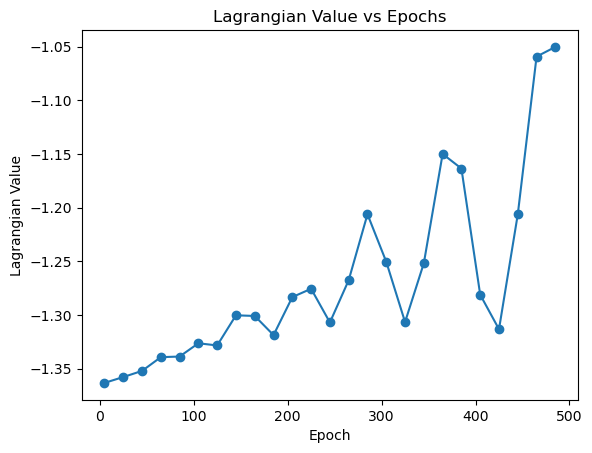

In [86]:
plt.plot(range(5, 500, 20), lagrangian_values[5:500:20], marker='o')
plt.xlabel('Epoch')
plt.ylabel('Lagrangian Value')
plt.title('Lagrangian Value vs Epochs')
plt.show()